In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing import image
import numpy as np
from collections import defaultdict
import os
import shutil
import random
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.models import load_model

2025-05-17 10:09:54.067110: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-17 10:09:54.073762: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-17 10:09:54.086998: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747472994.111635   20070 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747472994.118272   20070 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747472994.136563   20070 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os

# Diretórios
train_dir = './data/train'
val_dir = './data/val'
test_dir = './data/test'

img_size = (224, 224)
batch_size = 32

# Carregamento dos dados SEM data augmentation
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, image_size=img_size, batch_size=batch_size, label_mode='categorical')
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir, image_size=img_size, batch_size=batch_size, label_mode='categorical')
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir, image_size=img_size, batch_size=batch_size, label_mode='categorical')

# Pré-processamento
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)).cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)).cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y)).cache().prefetch(tf.data.AUTOTUNE)

# Modelo base
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False  # Congelado inicialmente

# Cabeça do modelo
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.6)(x)  # Dropout mais agressivo
output = layers.Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# Compilação inicial
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
checkpoint = ModelCheckpoint("best_resnet_model.h5", monitor='val_accuracy', save_best_only=True, verbose=1)

# Treinamento inicial
history_initial = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[early_stop])
model.save('resnet_pre_finetune.h5')

Found 8704 files belonging to 4 classes.
Found 1536 files belonging to 4 classes.


2025-05-17 10:09:59.254961: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Found 1279 files belonging to 4 classes.
Epoch 1/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 290s 1s/step - accuracy: 0.2830 - loss: 1.6428 - val_accuracy: 0.4694 - val_loss: 1.3346
Epoch 2/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 262s 964ms/step - accuracy: 0.3665 - loss: 1.3389 - val_accuracy: 0.4759 - val_loss: 1.2973
Epoch 3/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 260s 956ms/step - accuracy: 0.4132 - loss: 1.2980 - val_accuracy: 0.4727 - val_loss: 1.2646
Epoch 4/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 258s 948ms/step - accuracy: 0.4273 - loss: 1.2664 - val_accuracy: 0.4876 - val_loss: 1.2382
Epoch 5/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 257s 945ms/step - accuracy: 0.4378 - loss: 1.2457 - val_accuracy: 0.4655 - val_loss: 1.2203
Epoch 6/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 258s 949ms/step - accuracy: 0.4434 - loss: 1.2266 - val_accuracy: 0.4844 - val_loss: 1.2039
Epoch 7/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 257s 947ms/step - accuracy: 0.4683 - loss: 1.2117 - val_accuracy: 0.5169 - val_loss: 1.1878
Epoch 8/10
272/272 ━━━━━━━━━━━━━━━━━━━

Época 1: Treino Acc = 29.74%, Val Acc = 46.94%
Época 2: Treino Acc = 37.76%, Val Acc = 47.59%
Época 3: Treino Acc = 41.66%, Val Acc = 47.27%
Época 4: Treino Acc = 43.22%, Val Acc = 48.76%
Época 5: Treino Acc = 44.45%, Val Acc = 46.55%
Época 6: Treino Acc = 45.73%, Val Acc = 48.44%
Época 7: Treino Acc = 46.60%, Val Acc = 51.69%
Época 8: Treino Acc = 47.70%, Val Acc = 53.19%
Época 9: Treino Acc = 48.37%, Val Acc = 50.52%
Época 10: Treino Acc = 49.15%, Val Acc = 50.85%


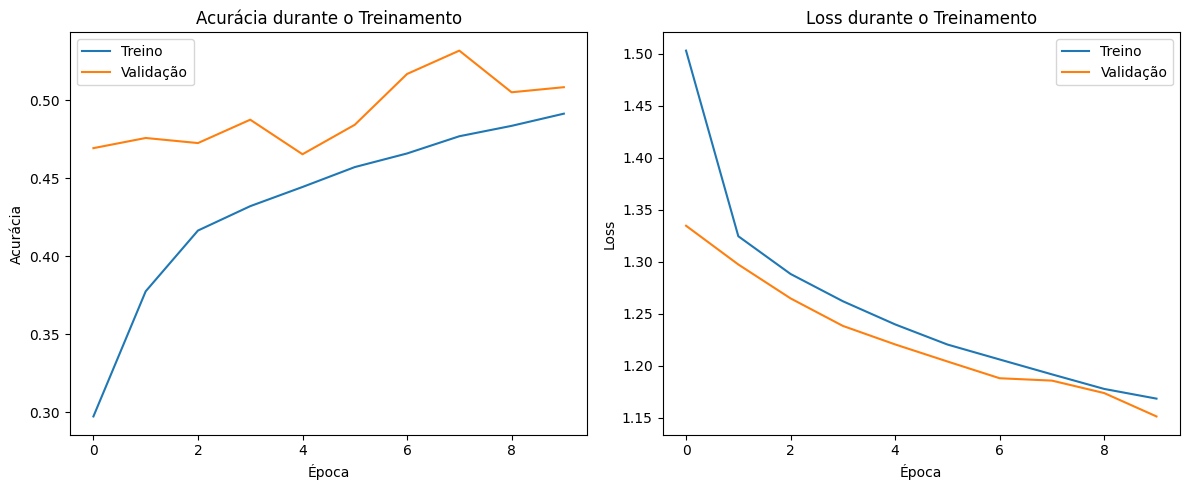

In [3]:
import matplotlib.pyplot as plt

# Acurácia
acc = history_initial.history['accuracy']
val_acc = history_initial.history['val_accuracy']

# Loss
loss = history_initial.history['loss']
val_loss = history_initial.history['val_loss']

epochs_range = range(len(acc))

# Imprimir acurácias por época
for epoch in epochs_range:
    print(f"Época {epoch + 1}: Treino Acc = {acc[epoch]*100:.2f}%, Val Acc = {val_acc[epoch]*100:.2f}%")

# Plot
plt.figure(figsize=(12, 5))

# Gráfico de Acurácia
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Treino')
plt.plot(epochs_range, val_acc, label='Validação')
plt.title('Acurácia durante o Treinamento')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

# Gráfico de Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Treino')
plt.plot(epochs_range, val_loss, label='Validação')
plt.title('Loss durante o Treinamento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [4]:
from tensorflow.keras.models import load_model
model = load_model('resnet_pre_finetune.h5')

# Descongelar últimas 50 camadas
for layer in model.layers[-50:]:
    if not isinstance(layer, layers.BatchNormalization):  # evita instabilidades
        layer.trainable = True

# Recompilar com otimizador AdamW
optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-5, weight_decay=1e-4)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks novamente
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
checkpoint = ModelCheckpoint("resnet_finetuned_best_model.h5", monitor='val_accuracy', save_best_only=True, verbose=1)

# Fine-tuning
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    initial_epoch=10,
    epochs=30,
    callbacks=[early_stop, lr_scheduler, checkpoint]
)

# Avaliação final
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"\n✅ Final Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Salvar modelo final
model.save('resnet_finetuned_model.h5')

Epoch 11/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4655 - loss: 1.2199
Epoch 11: val_accuracy improved from -inf to 0.67318, saving model to resnet_finetuned_best_model.h5


272/272 ━━━━━━━━━━━━━━━━━━━━ 421s 2s/step - accuracy: 0.4657 - loss: 1.2192 - val_accuracy: 0.6732 - val_loss: 0.7570 - learning_rate: 1.0000e-05
Epoch 12/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6152 - loss: 0.8331
Epoch 12: val_accuracy improved from 0.67318 to 0.70898, saving model to resnet_finetuned_best_model.h5


272/272 ━━━━━━━━━━━━━━━━━━━━ 419s 2s/step - accuracy: 0.6153 - loss: 0.8329 - val_accuracy: 0.7090 - val_loss: 0.7088 - learning_rate: 1.0000e-05
Epoch 13/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6657 - loss: 0.7491
Epoch 13: val_accuracy improved from 0.70898 to 0.72070, saving model to resnet_finetuned_best_model.h5


272/272 ━━━━━━━━━━━━━━━━━━━━ 417s 2s/step - accuracy: 0.6657 - loss: 0.7490 - val_accuracy: 0.7207 - val_loss: 0.6548 - learning_rate: 1.0000e-05
Epoch 14/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7091 - loss: 0.6631
Epoch 14: val_accuracy improved from 0.72070 to 0.77083, saving model to resnet_finetuned_best_model.h5


272/272 ━━━━━━━━━━━━━━━━━━━━ 416s 2s/step - accuracy: 0.7091 - loss: 0.6631 - val_accuracy: 0.7708 - val_loss: 0.5805 - learning_rate: 1.0000e-05
Epoch 15/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6993 - loss: 0.6686
Epoch 15: val_accuracy did not improve from 0.77083
272/272 ━━━━━━━━━━━━━━━━━━━━ 413s 2s/step - accuracy: 0.6993 - loss: 0.6685 - val_accuracy: 0.7598 - val_loss: 0.5515 - learning_rate: 1.0000e-05
Epoch 16/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7323 - loss: 0.6101
Epoch 16: val_accuracy did not improve from 0.77083
272/272 ━━━━━━━━━━━━━━━━━━━━ 418s 2s/step - accuracy: 0.7322 - loss: 0.6102 - val_accuracy: 0.6855 - val_loss: 0.6712 - learning_rate: 1.0000e-05
Epoch 17/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7345 - loss: 0.5923
Epoch 17: val_accuracy improved from 0.77083 to 0.78451, saving model to resnet_finetuned_best_model.h5


272/272 ━━━━━━━━━━━━━━━━━━━━ 412s 2s/step - accuracy: 0.7345 - loss: 0.5923 - val_accuracy: 0.7845 - val_loss: 0.5169 - learning_rate: 1.0000e-05
Epoch 18/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7503 - loss: 0.5883
Epoch 18: val_accuracy improved from 0.78451 to 0.80273, saving model to resnet_finetuned_best_model.h5


272/272 ━━━━━━━━━━━━━━━━━━━━ 410s 2s/step - accuracy: 0.7503 - loss: 0.5882 - val_accuracy: 0.8027 - val_loss: 0.4743 - learning_rate: 1.0000e-05
Epoch 19/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7577 - loss: 0.5510
Epoch 19: val_accuracy did not improve from 0.80273
272/272 ━━━━━━━━━━━━━━━━━━━━ 413s 2s/step - accuracy: 0.7577 - loss: 0.5511 - val_accuracy: 0.7604 - val_loss: 0.5398 - learning_rate: 1.0000e-05
Epoch 20/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7463 - loss: 0.5738
Epoch 20: val_accuracy did not improve from 0.80273
272/272 ━━━━━━━━━━━━━━━━━━━━ 414s 2s/step - accuracy: 0.7463 - loss: 0.5738 - val_accuracy: 0.7168 - val_loss: 0.6304 - learning_rate: 1.0000e-05
Epoch 21/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7511 - loss: 0.5468
Epoch 21: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 21: val_accuracy did not improve from 0.80273
272/272 ━━━━━━━━━━━━━━━━━━━━ 415s 2s/step - accuracy: 0.7512 - loss: 0

272/272 ━━━━━━━━━━━━━━━━━━━━ 417s 2s/step - accuracy: 0.8060 - loss: 0.4529 - val_accuracy: 0.8301 - val_loss: 0.4068 - learning_rate: 5.0000e-06
Epoch 24/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8018 - loss: 0.4550
Epoch 24: val_accuracy did not improve from 0.83008
272/272 ━━━━━━━━━━━━━━━━━━━━ 409s 2s/step - accuracy: 0.8018 - loss: 0.4549 - val_accuracy: 0.8125 - val_loss: 0.4178 - learning_rate: 5.0000e-06
Epoch 25/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8049 - loss: 0.4507
Epoch 25: val_accuracy did not improve from 0.83008
272/272 ━━━━━━━━━━━━━━━━━━━━ 409s 2s/step - accuracy: 0.8050 - loss: 0.4507 - val_accuracy: 0.8268 - val_loss: 0.4219 - learning_rate: 5.0000e-06
Epoch 26/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8235 - loss: 0.4215
Epoch 26: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 26: val_accuracy did not improve from 0.83008
272/272 ━━━━━━━━━━━━━━━━━━━━ 408s 2s/step - accuracy: 0.8235 - loss: 0

272/272 ━━━━━━━━━━━━━━━━━━━━ 409s 2s/step - accuracy: 0.8201 - loss: 0.4089 - val_accuracy: 0.8411 - val_loss: 0.3739 - learning_rate: 2.5000e-06
Epoch 28/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8345 - loss: 0.3926
Epoch 28: val_accuracy improved from 0.84115 to 0.84310, saving model to resnet_finetuned_best_model.h5


272/272 ━━━━━━━━━━━━━━━━━━━━ 409s 2s/step - accuracy: 0.8345 - loss: 0.3926 - val_accuracy: 0.8431 - val_loss: 0.3654 - learning_rate: 2.5000e-06
Epoch 29/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8378 - loss: 0.3745
Epoch 29: val_accuracy improved from 0.84310 to 0.84961, saving model to resnet_finetuned_best_model.h5


272/272 ━━━━━━━━━━━━━━━━━━━━ 408s 1s/step - accuracy: 0.8378 - loss: 0.3746 - val_accuracy: 0.8496 - val_loss: 0.3656 - learning_rate: 2.5000e-06
Epoch 30/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8252 - loss: 0.4078
Epoch 30: val_accuracy did not improve from 0.84961
272/272 ━━━━━━━━━━━━━━━━━━━━ 407s 1s/step - accuracy: 0.8252 - loss: 0.4078 - val_accuracy: 0.8372 - val_loss: 0.3786 - learning_rate: 2.5000e-06
40/40 ━━━━━━━━━━━━━━━━━━━━ 33s 811ms/step - accuracy: 0.6775 - loss: 0.6564



✅ Final Test Accuracy: 67.94%
Test Loss: 0.6557


In [9]:
# Avaliação no conjunto de validação
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"\n✅ Final Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")

# Avaliação no conjunto de teste
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"\n✅ Final Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


48/48 ━━━━━━━━━━━━━━━━━━━━ 41s 852ms/step - accuracy: 0.8420 - loss: 0.3646

✅ Final Validation Accuracy: 84.31%
Validation Loss: 0.3654
40/40 ━━━━━━━━━━━━━━━━━━━━ 34s 843ms/step - accuracy: 0.6775 - loss: 0.6564

✅ Final Test Accuracy: 67.94%
Test Loss: 0.6557


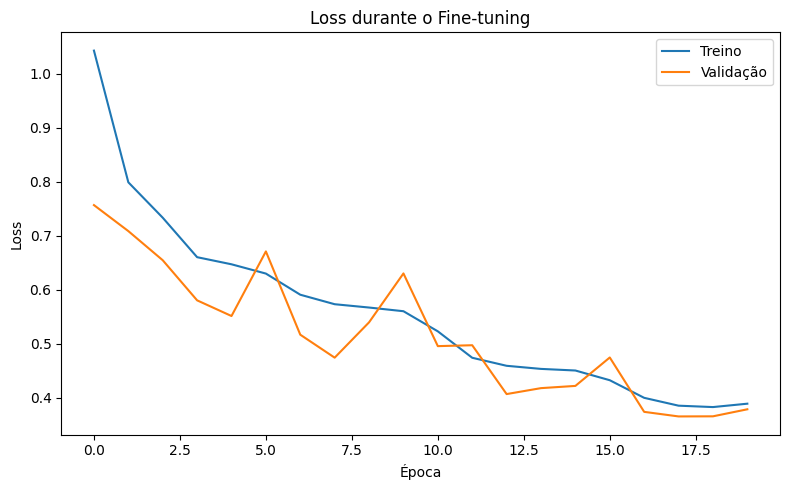

In [5]:
loss = history_finetune.history['loss']
val_loss = history_finetune.history['val_loss']

plt.figure(figsize=(8, 5))
plt.plot(loss, label='Treino')
plt.plot(val_loss, label='Validação')
plt.title('Loss durante o Fine-tuning')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()



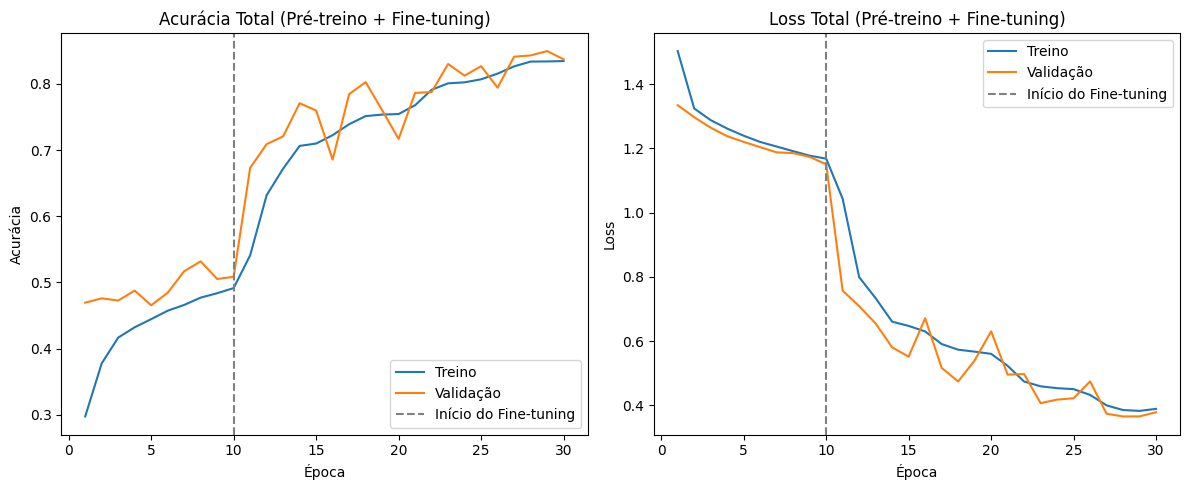

In [6]:
import matplotlib.pyplot as plt

# Dados do pré-treinamento
acc_pre = history_initial.history['accuracy']
val_acc_pre = history_initial.history['val_accuracy']
loss_pre = history_initial.history['loss']
val_loss_pre = history_initial.history['val_loss']

# Dados do fine-tuning
acc_ft = history_finetune.history['accuracy']
val_acc_ft = history_finetune.history['val_accuracy']
loss_ft = history_finetune.history['loss']
val_loss_ft = history_finetune.history['val_loss']

# Concatenar
acc_total = acc_pre + acc_ft
val_acc_total = val_acc_pre + val_acc_ft
loss_total = loss_pre + loss_ft
val_loss_total = val_loss_pre + val_loss_ft
epochs_range = range(1, len(acc_total) + 1)

# Plot combinado
plt.figure(figsize=(12, 5))

# Acurácia
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_total, label='Treino')
plt.plot(epochs_range, val_acc_total, label='Validação')
plt.axvline(x=len(acc_pre), color='gray', linestyle='--', label='Início do Fine-tuning')
plt.title('Acurácia Total (Pré-treino + Fine-tuning)')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_total, label='Treino')
plt.plot(epochs_range, val_loss_total, label='Validação')
plt.axvline(x=len(loss_pre), color='gray', linestyle='--', label='Início do Fine-tuning')
plt.title('Loss Total (Pré-treino + Fine-tuning)')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


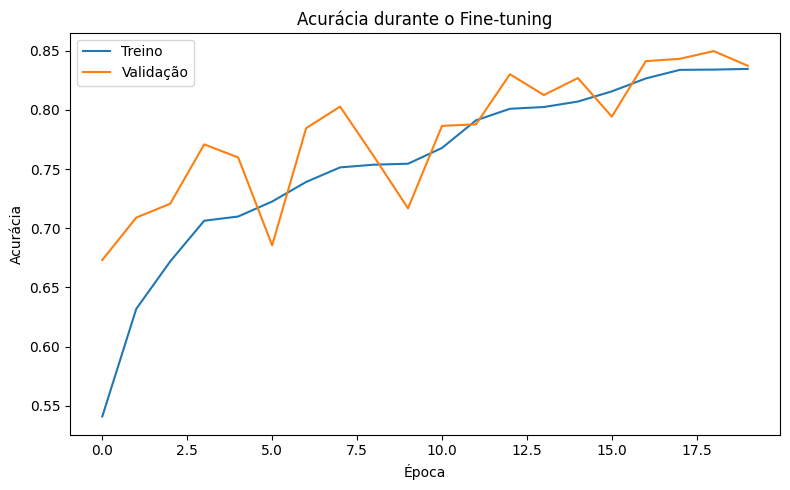

<Figure size 640x480 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt

# Acurácia durante o fine-tuning
acc = history_finetune.history['accuracy']
val_acc = history_finetune.history['val_accuracy']
epochs_range = range(len(acc))

plt.figure(figsize=(8, 5))
plt.plot(epochs_range, acc, label='Treino')
plt.plot(epochs_range, val_acc, label='Validação')
plt.title('Acurácia durante o Fine-tuning')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.tight_layout()
plt.show()

# Salvar o gráfico (opcional)
plt.savefig("acc_finetuning.png", dpi=300, bbox_inches='tight')


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
import numpy as np

# Diretórios
train_dir = './data/train'
val_dir = './data/val'
test_dir = './data/test'

img_size = (224, 224)
batch_size = 32

# Dados com label_mode='int'
train_ds_raw = tf.keras.utils.image_dataset_from_directory(train_dir, image_size=img_size, batch_size=batch_size, label_mode='int')
val_ds = tf.keras.utils.image_dataset_from_directory(val_dir, image_size=img_size, batch_size=batch_size, label_mode='int')
test_ds = tf.keras.utils.image_dataset_from_directory(test_dir, image_size=img_size, batch_size=batch_size, label_mode='int')

# Detectar classes
class_names = train_ds_raw.class_names
num_classes = len(class_names)
print(f"Número de classes detectado: {num_classes}")
print("Classes:", class_names)

# Normalização + one-hot encoding
normalization = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds_raw.map(lambda x, y: (normalization(x), tf.one_hot(y, num_classes))).cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (normalization(x), tf.one_hot(y, num_classes))).cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (normalization(x), tf.one_hot(y, num_classes))).cache().prefetch(tf.data.AUTOTUNE)

# Coletar rótulos para class_weight
raw_labels = []
for _, y in train_ds_raw.unbatch():
    raw_labels.append(int(y.numpy()))
all_labels = np.array(raw_labels)

# Calcular class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(all_labels), y=all_labels)
class_weights = dict(enumerate(class_weights))

# Modelo base
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.6)(x)
output = layers.Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
checkpoint = ModelCheckpoint("resnet_finetuned_best_model2.h5", monitor='val_accuracy', save_best_only=True, verbose=1)

# Treinamento inicial
history_initial = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[early_stop], class_weight=class_weights)
model.save('resnet_pre_finetune2.h5')

# Descongelar últimas 100 camadas
model = load_model('resnet_pre_finetune2.h5')
for layer in model.layers[-100:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

# Recompilar
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-5, weight_decay=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tuning
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    initial_epoch=10,
    epochs=30,
    class_weight=class_weights,
    callbacks=[early_stop, lr_scheduler, checkpoint]
)

model.save('resnet_finetuned_model2.h5')

# Avaliar melhor modelo
best_model = load_model('resnet_finetuned_best_model2.h5')

val_loss, val_accuracy = best_model.evaluate(val_ds)
print(f"\n📊 Val Accuracy: {val_accuracy * 100:.2f}%, Loss: {val_loss:.4f}")

test_loss, test_accuracy = best_model.evaluate(test_ds)
print(f"✅ Test Accuracy: {test_accuracy * 100:.2f}%, Loss: {test_loss:.4f}")

# TTA
def predict_with_tta(model, dataset, num_passes=5):
    all_preds = []
    for i in range(num_passes):
        print(f"TTA Passagem {i+1}/{num_passes}")
        preds = []
        for batch, _ in dataset:
            augmented = tf.image.random_flip_left_right(batch)
            batch_preds = model.predict(augmented, verbose=0)
            preds.extend(batch_preds)
        all_preds.append(np.array(preds))
    return np.mean(np.array(all_preds), axis=0)

tta_preds = predict_with_tta(best_model, test_ds)
y_pred = np.argmax(tta_preds, axis=1)

# Rótulos reais
y_true = []
for _, labels in test_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))

tta_acc = accuracy_score(y_true, y_pred)
print(f"\n🧪 Test Accuracy com TTA: {tta_acc * 100:.2f}%")


2025-05-17 17:18:55.506056: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-17 17:18:55.622694: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-17 17:18:55.733400: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747498735.841854  237119 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747498735.877566  237119 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747498736.093869  237119 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Found 8704 files belonging to 4 classes.
Found 1536 files belonging to 4 classes.


2025-05-17 17:19:02.279667: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Found 1279 files belonging to 4 classes.
Número de classes detectado: 4
Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']


2025-05-17 17:19:05.308579: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 291s 1s/step - accuracy: 0.2610 - loss: 1.6285 - val_accuracy: 0.4245 - val_loss: 1.3439
Epoch 2/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 261s 960ms/step - accuracy: 0.3744 - loss: 1.3412 - val_accuracy: 0.4486 - val_loss: 1.3029
Epoch 3/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 260s 955ms/step - accuracy: 0.4094 - loss: 1.2973 - val_accuracy: 0.5020 - val_loss: 1.2682
Epoch 4/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 259s 953ms/step - accuracy: 0.4260 - loss: 1.2698 - val_accuracy: 0.5072 - val_loss: 1.2418
Epoch 5/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 259s 955ms/step - accuracy: 0.4382 - loss: 1.2507 - val_accuracy: 0.4818 - val_loss: 1.2207
Epoch 6/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 258s 949ms/step - accuracy: 0.4490 - loss: 1.2282 - val_accuracy: 0.5072 - val_loss: 1.2027
Epoch 7/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 259s 952ms/step - accuracy: 0.4738 - loss: 1.2042 - val_accuracy: 0.5098 - val_loss: 1.1879
Epoch 8/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 258s 947ms/step - accuracy: 0.4719 - lo

Epoch 11/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4376 - loss: 1.2476
Epoch 11: val_accuracy improved from -inf to 0.63281, saving model to resnet_finetuned_best_model2.h5


272/272 ━━━━━━━━━━━━━━━━━━━━ 550s 2s/step - accuracy: 0.4378 - loss: 1.2470 - val_accuracy: 0.6328 - val_loss: 0.7946 - learning_rate: 1.0000e-05
Epoch 12/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6273 - loss: 0.7857
Epoch 12: val_accuracy improved from 0.63281 to 0.70573, saving model to resnet_finetuned_best_model2.h5


272/272 ━━━━━━━━━━━━━━━━━━━━ 541s 2s/step - accuracy: 0.6273 - loss: 0.7856 - val_accuracy: 0.7057 - val_loss: 0.6777 - learning_rate: 1.0000e-05
Epoch 13/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6732 - loss: 0.7056
Epoch 13: val_accuracy did not improve from 0.70573
272/272 ━━━━━━━━━━━━━━━━━━━━ 538s 2s/step - accuracy: 0.6733 - loss: 0.7055 - val_accuracy: 0.6608 - val_loss: 0.7005 - learning_rate: 1.0000e-05
Epoch 14/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7071 - loss: 0.6433
Epoch 14: val_accuracy improved from 0.70573 to 0.74023, saving model to resnet_finetuned_best_model2.h5


272/272 ━━━━━━━━━━━━━━━━━━━━ 538s 2s/step - accuracy: 0.7071 - loss: 0.6433 - val_accuracy: 0.7402 - val_loss: 0.5842 - learning_rate: 1.0000e-05
Epoch 15/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7413 - loss: 0.5868
Epoch 15: val_accuracy improved from 0.74023 to 0.80013, saving model to resnet_finetuned_best_model2.h5


272/272 ━━━━━━━━━━━━━━━━━━━━ 539s 2s/step - accuracy: 0.7413 - loss: 0.5867 - val_accuracy: 0.8001 - val_loss: 0.4686 - learning_rate: 1.0000e-05
Epoch 16/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7795 - loss: 0.5038
Epoch 16: val_accuracy improved from 0.80013 to 0.81185, saving model to resnet_finetuned_best_model2.h5


272/272 ━━━━━━━━━━━━━━━━━━━━ 539s 2s/step - accuracy: 0.7794 - loss: 0.5038 - val_accuracy: 0.8118 - val_loss: 0.4331 - learning_rate: 1.0000e-05
Epoch 17/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7935 - loss: 0.4749
Epoch 17: val_accuracy improved from 0.81185 to 0.82617, saving model to resnet_finetuned_best_model2.h5


272/272 ━━━━━━━━━━━━━━━━━━━━ 541s 2s/step - accuracy: 0.7934 - loss: 0.4749 - val_accuracy: 0.8262 - val_loss: 0.4111 - learning_rate: 1.0000e-05
Epoch 18/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7938 - loss: 0.4609
Epoch 18: val_accuracy did not improve from 0.82617
272/272 ━━━━━━━━━━━━━━━━━━━━ 538s 2s/step - accuracy: 0.7938 - loss: 0.4610 - val_accuracy: 0.8262 - val_loss: 0.4049 - learning_rate: 1.0000e-05
Epoch 19/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8042 - loss: 0.4372
Epoch 19: val_accuracy improved from 0.82617 to 0.85091, saving model to resnet_finetuned_best_model2.h5


272/272 ━━━━━━━━━━━━━━━━━━━━ 543s 2s/step - accuracy: 0.8042 - loss: 0.4371 - val_accuracy: 0.8509 - val_loss: 0.3648 - learning_rate: 1.0000e-05
Epoch 20/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8223 - loss: 0.4154
Epoch 20: val_accuracy did not improve from 0.85091
272/272 ━━━━━━━━━━━━━━━━━━━━ 540s 2s/step - accuracy: 0.8223 - loss: 0.4154 - val_accuracy: 0.7826 - val_loss: 0.4732 - learning_rate: 1.0000e-05
Epoch 21/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8261 - loss: 0.3987
Epoch 21: val_accuracy did not improve from 0.85091
272/272 ━━━━━━━━━━━━━━━━━━━━ 539s 2s/step - accuracy: 0.8261 - loss: 0.3986 - val_accuracy: 0.8366 - val_loss: 0.3563 - learning_rate: 1.0000e-05
Epoch 22/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8471 - loss: 0.3624
Epoch 22: val_accuracy improved from 0.85091 to 0.85286, saving model to resnet_finetuned_best_model2.h5


272/272 ━━━━━━━━━━━━━━━━━━━━ 539s 2s/step - accuracy: 0.8471 - loss: 0.3625 - val_accuracy: 0.8529 - val_loss: 0.3396 - learning_rate: 1.0000e-05
Epoch 23/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8597 - loss: 0.3445
Epoch 23: val_accuracy did not improve from 0.85286
272/272 ━━━━━━━━━━━━━━━━━━━━ 537s 2s/step - accuracy: 0.8597 - loss: 0.3445 - val_accuracy: 0.8411 - val_loss: 0.3596 - learning_rate: 1.0000e-05
Epoch 24/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8594 - loss: 0.3200
Epoch 24: val_accuracy improved from 0.85286 to 0.86198, saving model to resnet_finetuned_best_model2.h5


272/272 ━━━━━━━━━━━━━━━━━━━━ 538s 2s/step - accuracy: 0.8594 - loss: 0.3201 - val_accuracy: 0.8620 - val_loss: 0.3353 - learning_rate: 1.0000e-05
Epoch 25/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8693 - loss: 0.3140
Epoch 25: val_accuracy improved from 0.86198 to 0.88216, saving model to resnet_finetuned_best_model2.h5


272/272 ━━━━━━━━━━━━━━━━━━━━ 542s 2s/step - accuracy: 0.8693 - loss: 0.3139 - val_accuracy: 0.8822 - val_loss: 0.2831 - learning_rate: 1.0000e-05
Epoch 26/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8848 - loss: 0.2769
Epoch 26: val_accuracy improved from 0.88216 to 0.89128, saving model to resnet_finetuned_best_model2.h5


272/272 ━━━━━━━━━━━━━━━━━━━━ 541s 2s/step - accuracy: 0.8848 - loss: 0.2769 - val_accuracy: 0.8913 - val_loss: 0.2647 - learning_rate: 1.0000e-05
Epoch 27/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8956 - loss: 0.2734
Epoch 27: val_accuracy did not improve from 0.89128
272/272 ━━━━━━━━━━━━━━━━━━━━ 539s 2s/step - accuracy: 0.8956 - loss: 0.2734 - val_accuracy: 0.8893 - val_loss: 0.2709 - learning_rate: 1.0000e-05
Epoch 28/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9050 - loss: 0.2393
Epoch 28: val_accuracy improved from 0.89128 to 0.89974, saving model to resnet_finetuned_best_model2.h5


272/272 ━━━━━━━━━━━━━━━━━━━━ 539s 2s/step - accuracy: 0.9050 - loss: 0.2393 - val_accuracy: 0.8997 - val_loss: 0.2575 - learning_rate: 1.0000e-05
Epoch 29/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9172 - loss: 0.2153
Epoch 29: val_accuracy did not improve from 0.89974
272/272 ━━━━━━━━━━━━━━━━━━━━ 540s 2s/step - accuracy: 0.9172 - loss: 0.2153 - val_accuracy: 0.8952 - val_loss: 0.2584 - learning_rate: 1.0000e-05
Epoch 30/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9252 - loss: 0.2014
Epoch 30: val_accuracy did not improve from 0.89974
272/272 ━━━━━━━━━━━━━━━━━━━━ 540s 2s/step - accuracy: 0.9252 - loss: 0.2014 - val_accuracy: 0.8431 - val_loss: 0.4270 - learning_rate: 1.0000e-05


48/48 ━━━━━━━━━━━━━━━━━━━━ 46s 817ms/step - accuracy: 0.9099 - loss: 0.2482

📊 Val Accuracy: 89.97%, Loss: 0.2575
40/40 ━━━━━━━━━━━━━━━━━━━━ 33s 824ms/step - accuracy: 0.7638 - loss: 0.5228
✅ Test Accuracy: 76.94%, Loss: 0.5168
TTA Passagem 1/5


2025-05-17 21:04:49.045197: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


TTA Passagem 2/5
TTA Passagem 3/5


2025-05-17 21:05:58.794049: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


TTA Passagem 4/5
TTA Passagem 5/5

🧪 Test Accuracy com TTA: 68.80%


[[102   2  17  58]
 [  1   7   1   3]
 [ 17   1 464 158]
 [ 29   4 108 307]]
                      precision    recall  f1-score   support

     Mild Impairment       0.68      0.57      0.62       179
 Moderate Impairment       0.50      0.58      0.54        12
       No Impairment       0.79      0.72      0.75       640
Very Mild Impairment       0.58      0.69      0.63       448

            accuracy                           0.69      1279
           macro avg       0.64      0.64      0.64      1279
        weighted avg       0.70      0.69      0.69      1279



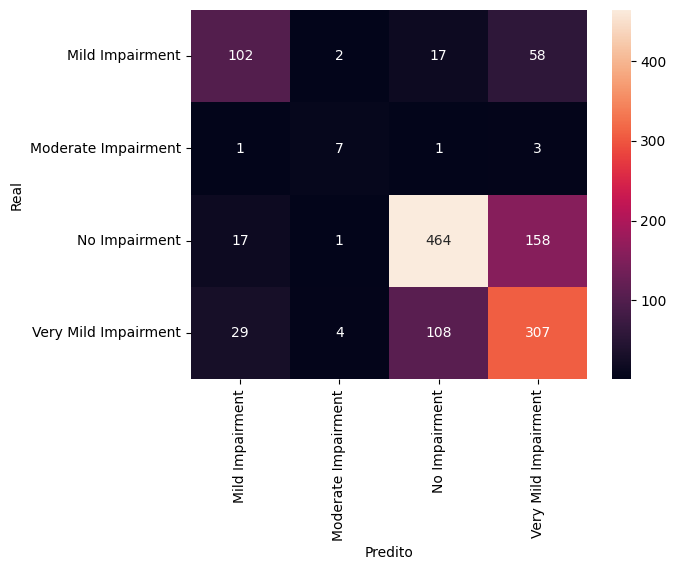

In [3]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=class_names))

# Opcional: Heatmap
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
import numpy as np

# Diretórios (certifique-se de que NÃO há a pasta "Moderate Impairment")
train_dir = './data_no_moderate/train'
val_dir = './data_no_moderate/val'
test_dir = './data_no_moderate/test'

img_size = (224, 224)
batch_size = 32

# Carregar datasets sem "Moderate Impairment"
train_ds_raw = tf.keras.utils.image_dataset_from_directory(train_dir, image_size=img_size, batch_size=batch_size, label_mode='int')
val_ds_raw = tf.keras.utils.image_dataset_from_directory(val_dir, image_size=img_size, batch_size=batch_size, label_mode='int')
test_ds_raw = tf.keras.utils.image_dataset_from_directory(test_dir, image_size=img_size, batch_size=batch_size, label_mode='int')

# Atualizar classes detectadas
class_names = train_ds_raw.class_names
num_classes = len(class_names)
print(f"Classes: {class_names}")

# Normalização + one-hot
normalization = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds_raw.map(lambda x, y: (normalization(x), tf.one_hot(y, num_classes))).cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds_raw.map(lambda x, y: (normalization(x), tf.one_hot(y, num_classes))).cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds_raw.map(lambda x, y: (normalization(x), tf.one_hot(y, num_classes))).cache().prefetch(tf.data.AUTOTUNE)

# Recalcular class_weights
raw_labels = []
for _, y in train_ds_raw.unbatch():
    raw_labels.append(int(y.numpy()))
all_labels = np.array(raw_labels)
class_weights = compute_class_weight('balanced', classes=np.unique(all_labels), y=all_labels)
class_weights = dict(enumerate(class_weights))

# Modelo base
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.6)(x)
output = layers.Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# Compilação
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
checkpoint = ModelCheckpoint("resnet_best_nomoderate.keras", monitor='val_accuracy', save_best_only=True, verbose=1)

# Treinamento
history = model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=[early_stop, lr_scheduler, checkpoint], class_weight=class_weights)

# Avaliação
model = load_model("resnet_best_nomoderate.keras")
loss, acc = model.evaluate(test_ds)
print(f"Test Accuracy (sem Moderate): {acc*100:.2f}%, Loss: {loss:.4f}")


Found 6528 files belonging to 3 classes.
Found 1152 files belonging to 3 classes.
Found 1267 files belonging to 3 classes.


2025-05-17 21:33:01.770189: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Classes: ['Mild Impairment', 'No Impairment', 'Very Mild Impairment']


2025-05-17 21:33:04.033561: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 901ms/step - accuracy: 0.3502 - loss: 1.3337
Epoch 1: val_accuracy improved from -inf to 0.37413, saving model to resnet_best_nomoderate.keras
204/204 ━━━━━━━━━━━━━━━━━━━━ 224s 1s/step - accuracy: 0.3502 - loss: 1.3332 - val_accuracy: 0.3741 - val_loss: 1.1023 - learning_rate: 1.0000e-04
Epoch 2/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 840ms/step - accuracy: 0.3745 - loss: 1.1115
Epoch 2: val_accuracy improved from 0.37413 to 0.45573, saving model to resnet_best_nomoderate.keras
204/204 ━━━━━━━━━━━━━━━━━━━━ 202s 988ms/step - accuracy: 0.3746 - loss: 1.1114 - val_accuracy: 0.4557 - val_loss: 1.0867 - learning_rate: 1.0000e-04
Epoch 3/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 827ms/step - accuracy: 0.4011 - loss: 1.0928
Epoch 3: val_accuracy improved from 0.45573 to 0.48177, saving model to resnet_best_nomoderate.keras
204/204 ━━━━━━━━━━━━━━━━━━━━ 199s 976ms/step - accuracy: 0.4011 - loss: 1.0927 - val_accuracy: 0.4818 - val_loss: 1.0755 - learning_rate: 1.0

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
import numpy as np

# Diretórios (sem a classe "Moderate Impairment")
train_dir = './data_no_moderate/train'
val_dir = './data_no_moderate/val'
test_dir = './data_no_moderate/test'

img_size = (224, 224)
batch_size = 32

# Carregar datasets (labels em int)
train_ds_raw = tf.keras.utils.image_dataset_from_directory(train_dir, image_size=img_size, batch_size=batch_size, label_mode='int')
val_ds_raw = tf.keras.utils.image_dataset_from_directory(val_dir, image_size=img_size, batch_size=batch_size, label_mode='int')
test_ds_raw = tf.keras.utils.image_dataset_from_directory(test_dir, image_size=img_size, batch_size=batch_size, label_mode='int')

# Informações das classes
class_names = train_ds_raw.class_names
num_classes = len(class_names)
print(f"Classes detectadas: {class_names}")

# Normalização + one-hot
normalization = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds_raw.map(lambda x, y: (normalization(x), tf.one_hot(y, num_classes))).cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds_raw.map(lambda x, y: (normalization(x), tf.one_hot(y, num_classes))).cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds_raw.map(lambda x, y: (normalization(x), tf.one_hot(y, num_classes))).cache().prefetch(tf.data.AUTOTUNE)

# Class weights
raw_labels = [int(y.numpy()) for _, y in train_ds_raw.unbatch()]
class_weights = compute_class_weight('balanced', classes=np.unique(raw_labels), y=raw_labels)
class_weights = dict(enumerate(class_weights))

# Modelo base
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.6)(x)
output = layers.Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
checkpoint = ModelCheckpoint("resnet_finetuned_best_model_no_mod.h5", monitor='val_accuracy', save_best_only=True, verbose=1)

# Treinamento inicial
history_initial = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[early_stop], class_weight=class_weights)
model.save('resnet_pre_finetune_no_mod.h5')

# Fine-tuning
model = load_model('resnet_pre_finetune_no_mod.h5')
for layer in model.layers[-100:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-5, weight_decay=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_finetune = model.fit(train_ds, validation_data=val_ds, initial_epoch=10, epochs=30,
                             class_weight=class_weights,
                             callbacks=[early_stop, lr_scheduler, checkpoint])

model.save('resnet_finetuned_model_no_mod.h5')

# Avaliação
best_model = load_model('resnet_finetuned_best_model_no_mod.h5')
val_loss, val_accuracy = best_model.evaluate(val_ds)
print(f"\n📊 Val Accuracy: {val_accuracy * 100:.2f}%, Loss: {val_loss:.4f}")
test_loss, test_accuracy = best_model.evaluate(test_ds)
print(f"✅ Test Accuracy: {test_accuracy * 100:.2f}%, Loss: {test_loss:.4f}")

# Test Time Augmentation (TTA)
def predict_with_tta(model, dataset, num_passes=5):
    all_preds = []
    for i in range(num_passes):
        print(f"TTA Passagem {i+1}/{num_passes}")
        preds = []
        for batch, _ in dataset:
            augmented = tf.image.random_flip_left_right(batch)
            batch_preds = model.predict(augmented, verbose=0)
            preds.extend(batch_preds)
        all_preds.append(np.array(preds))
    return np.mean(np.array(all_preds), axis=0)

tta_preds = predict_with_tta(best_model, test_ds)
y_pred = np.argmax(tta_preds, axis=1)

# Rótulos reais
y_true = []
for _, labels in test_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))

tta_acc = accuracy_score(y_true, y_pred)
print(f"\n🧪 Test Accuracy com TTA: {tta_acc * 100:.2f}%")


Found 6528 files belonging to 3 classes.
Found 1152 files belonging to 3 classes.
Found 1267 files belonging to 3 classes.
Classes detectadas: ['Mild Impairment', 'No Impairment', 'Very Mild Impairment']


2025-05-19 11:20:29.354714: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 215s 1s/step - accuracy: 0.3424 - loss: 1.4275 - val_accuracy: 0.4731 - val_loss: 1.0986
Epoch 2/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.3838 - loss: 1.1102 - val_accuracy: 0.4609 - val_loss: 1.0817
Epoch 3/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 194s 953ms/step - accuracy: 0.3924 - loss: 1.0921 - val_accuracy: 0.3880 - val_loss: 1.0794
Epoch 4/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 193s 945ms/step - accuracy: 0.4082 - loss: 1.0809 - val_accuracy: 0.4870 - val_loss: 1.0681
Epoch 5/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 193s 945ms/step - accuracy: 0.4364 - loss: 1.0700 - val_accuracy: 0.4609 - val_loss: 1.0669
Epoch 6/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 198s 970ms/step - accuracy: 0.4430 - loss: 1.0689 - val_accuracy: 0.4826 - val_loss: 1.0571
Epoch 7/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 195s 958ms/step - accuracy: 0.4617 - loss: 1.0602 - val_accuracy: 0.4887 - val_loss: 1.0513
Epoch 8/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 196s 962ms/step - accuracy: 0.4609 - loss:

Epoch 11/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3842 - loss: 1.1275
Epoch 11: val_accuracy improved from -inf to 0.48785, saving model to resnet_finetuned_best_model_no_mod.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 405s 2s/step - accuracy: 0.3844 - loss: 1.1273 - val_accuracy: 0.4878 - val_loss: 1.0086 - learning_rate: 1.0000e-05
Epoch 12/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5037 - loss: 0.9890
Epoch 12: val_accuracy improved from 0.48785 to 0.54427, saving model to resnet_finetuned_best_model_no_mod.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 396s 2s/step - accuracy: 0.5039 - loss: 0.9888 - val_accuracy: 0.5443 - val_loss: 0.9305 - learning_rate: 1.0000e-05
Epoch 13/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5959 - loss: 0.8470
Epoch 13: val_accuracy improved from 0.54427 to 0.67969, saving model to resnet_finetuned_best_model_no_mod.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 395s 2s/step - accuracy: 0.5960 - loss: 0.8469 - val_accuracy: 0.6797 - val_loss: 0.7015 - learning_rate: 1.0000e-05
Epoch 14/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6638 - loss: 0.7436
Epoch 14: val_accuracy improved from 0.67969 to 0.74566, saving model to resnet_finetuned_best_model_no_mod.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 397s 2s/step - accuracy: 0.6638 - loss: 0.7436 - val_accuracy: 0.7457 - val_loss: 0.6089 - learning_rate: 1.0000e-05
Epoch 15/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6947 - loss: 0.6782
Epoch 15: val_accuracy did not improve from 0.74566
204/204 ━━━━━━━━━━━━━━━━━━━━ 396s 2s/step - accuracy: 0.6947 - loss: 0.6781 - val_accuracy: 0.7370 - val_loss: 0.5770 - learning_rate: 1.0000e-05
Epoch 16/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7348 - loss: 0.5974
Epoch 16: val_accuracy improved from 0.74566 to 0.75608, saving model to resnet_finetuned_best_model_no_mod.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 399s 2s/step - accuracy: 0.7348 - loss: 0.5975 - val_accuracy: 0.7561 - val_loss: 0.5458 - learning_rate: 1.0000e-05
Epoch 17/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7446 - loss: 0.5653
Epoch 17: val_accuracy improved from 0.75608 to 0.77257, saving model to resnet_finetuned_best_model_no_mod.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 397s 2s/step - accuracy: 0.7446 - loss: 0.5653 - val_accuracy: 0.7726 - val_loss: 0.5209 - learning_rate: 1.0000e-05
Epoch 18/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7555 - loss: 0.5542
Epoch 18: val_accuracy did not improve from 0.77257
204/204 ━━━━━━━━━━━━━━━━━━━━ 399s 2s/step - accuracy: 0.7555 - loss: 0.5541 - val_accuracy: 0.7717 - val_loss: 0.5202 - learning_rate: 1.0000e-05
Epoch 19/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7648 - loss: 0.5228
Epoch 19: val_accuracy did not improve from 0.77257
204/204 ━━━━━━━━━━━━━━━━━━━━ 396s 2s/step - accuracy: 0.7649 - loss: 0.5228 - val_accuracy: 0.7578 - val_loss: 0.5544 - learning_rate: 1.0000e-05
Epoch 20/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7689 - loss: 0.5329
Epoch 20: val_accuracy improved from 0.77257 to 0.78993, saving model to resnet_finetuned_best_model_no_mod.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 396s 2s/step - accuracy: 0.7689 - loss: 0.5328 - val_accuracy: 0.7899 - val_loss: 0.4679 - learning_rate: 1.0000e-05
Epoch 21/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8048 - loss: 0.4512
Epoch 21: val_accuracy improved from 0.78993 to 0.80816, saving model to resnet_finetuned_best_model_no_mod.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 398s 2s/step - accuracy: 0.8048 - loss: 0.4512 - val_accuracy: 0.8082 - val_loss: 0.4426 - learning_rate: 1.0000e-05
Epoch 22/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8212 - loss: 0.4283
Epoch 22: val_accuracy improved from 0.80816 to 0.82899, saving model to resnet_finetuned_best_model_no_mod.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 398s 2s/step - accuracy: 0.8211 - loss: 0.4283 - val_accuracy: 0.8290 - val_loss: 0.4030 - learning_rate: 1.0000e-05
Epoch 23/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8286 - loss: 0.4094
Epoch 23: val_accuracy did not improve from 0.82899
204/204 ━━━━━━━━━━━━━━━━━━━━ 398s 2s/step - accuracy: 0.8287 - loss: 0.4093 - val_accuracy: 0.8012 - val_loss: 0.4572 - learning_rate: 1.0000e-05
Epoch 24/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8312 - loss: 0.3992
Epoch 24: val_accuracy improved from 0.82899 to 0.85243, saving model to resnet_finetuned_best_model_no_mod.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 399s 2s/step - accuracy: 0.8312 - loss: 0.3992 - val_accuracy: 0.8524 - val_loss: 0.3571 - learning_rate: 1.0000e-05
Epoch 25/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8576 - loss: 0.3481
Epoch 25: val_accuracy did not improve from 0.85243
204/204 ━━━━━━━━━━━━━━━━━━━━ 393s 2s/step - accuracy: 0.8576 - loss: 0.3481 - val_accuracy: 0.8472 - val_loss: 0.3812 - learning_rate: 1.0000e-05
Epoch 26/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8713 - loss: 0.3163
Epoch 26: val_accuracy did not improve from 0.85243
204/204 ━━━━━━━━━━━━━━━━━━━━ 394s 2s/step - accuracy: 0.8713 - loss: 0.3163 - val_accuracy: 0.8090 - val_loss: 0.4256 - learning_rate: 1.0000e-05
Epoch 27/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8789 - loss: 0.2935
Epoch 27: val_accuracy improved from 0.85243 to 0.85590, saving model to resnet_finetuned_best_model_no_mod.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 394s 2s/step - accuracy: 0.8789 - loss: 0.2936 - val_accuracy: 0.8559 - val_loss: 0.3299 - learning_rate: 1.0000e-05
Epoch 28/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9013 - loss: 0.2588
Epoch 28: val_accuracy improved from 0.85590 to 0.86632, saving model to resnet_finetuned_best_model_no_mod.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 398s 2s/step - accuracy: 0.9012 - loss: 0.2589 - val_accuracy: 0.8663 - val_loss: 0.3198 - learning_rate: 1.0000e-05
Epoch 29/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9018 - loss: 0.2535
Epoch 29: val_accuracy improved from 0.86632 to 0.89931, saving model to resnet_finetuned_best_model_no_mod.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 399s 2s/step - accuracy: 0.9018 - loss: 0.2535 - val_accuracy: 0.8993 - val_loss: 0.2587 - learning_rate: 1.0000e-05
Epoch 30/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9076 - loss: 0.2418
Epoch 30: val_accuracy did not improve from 0.89931
204/204 ━━━━━━━━━━━━━━━━━━━━ 398s 2s/step - accuracy: 0.9076 - loss: 0.2419 - val_accuracy: 0.8533 - val_loss: 0.3253 - learning_rate: 1.0000e-05


36/36 ━━━━━━━━━━━━━━━━━━━━ 31s 804ms/step - accuracy: 0.8859 - loss: 0.3144

📊 Val Accuracy: 89.93%, Loss: 0.2587
40/40 ━━━━━━━━━━━━━━━━━━━━ 33s 829ms/step - accuracy: 0.8146 - loss: 0.4219
✅ Test Accuracy: 82.64%, Loss: 0.4087
TTA Passagem 1/5


2025-05-19 14:07:46.019616: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


TTA Passagem 2/5
TTA Passagem 3/5


2025-05-19 14:08:55.848430: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


TTA Passagem 4/5
TTA Passagem 5/5

🧪 Test Accuracy com TTA: 74.59%


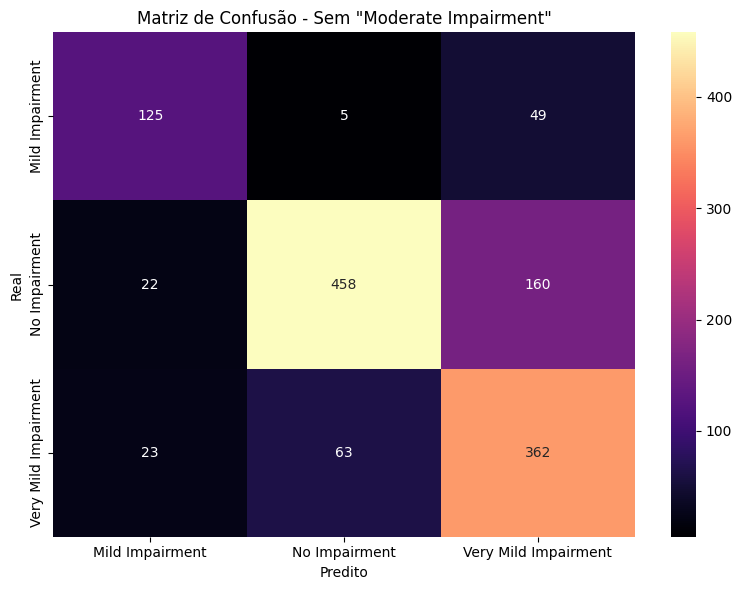


📋 Classification Report:

                      precision    recall  f1-score   support

     Mild Impairment       0.74      0.70      0.72       179
       No Impairment       0.87      0.72      0.79       640
Very Mild Impairment       0.63      0.81      0.71       448

            accuracy                           0.75      1267
           macro avg       0.75      0.74      0.74      1267
        weighted avg       0.77      0.75      0.75      1267



In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Matriz de confusão
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='magma', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Sem "Moderate Impairment"')
plt.tight_layout()
plt.show()

# Relatório de classificação
print("\n📋 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


/tmp/ipykernel_8974/4249183910.py:21: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/tomas/TAA/Trabalho2/TAA-Project-2/tfenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


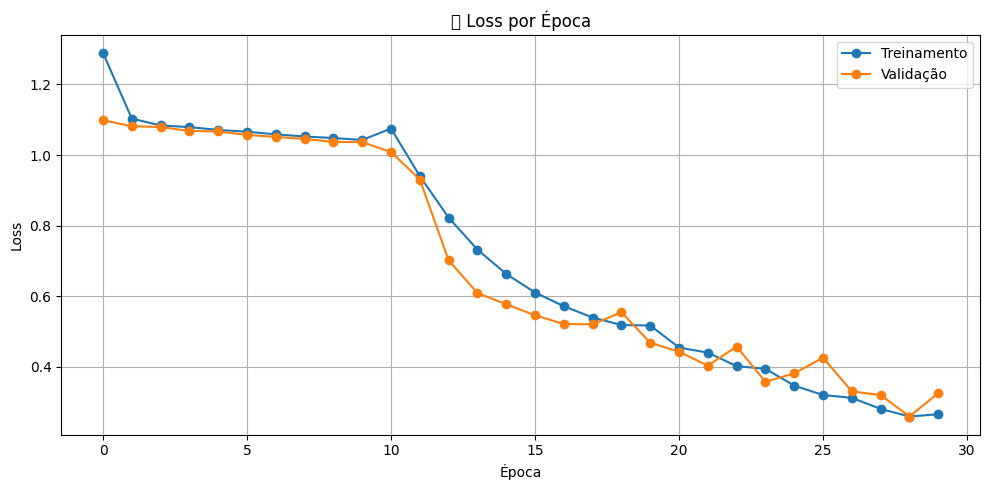

/tmp/ipykernel_8974/4249183910.py:33: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/tomas/TAA/Trabalho2/TAA-Project-2/tfenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


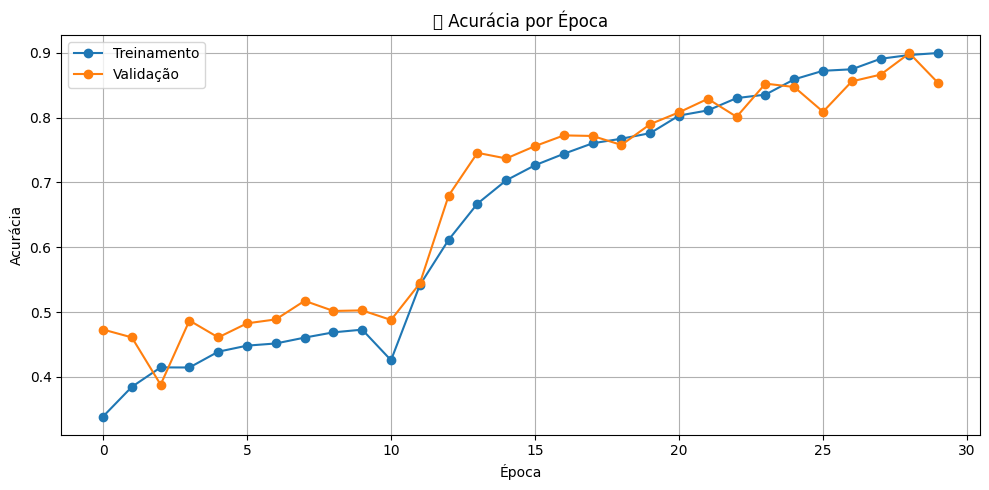

In [5]:
import matplotlib.pyplot as plt

# Juntar históricos
def combine_history(h1, h2):
    history = {}
    for key in h1.history:
        history[key] = h1.history[key] + h2.history[key]
    return history

combined_history = combine_history(history_initial, history_finetune)

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(combined_history['loss'], label='Treinamento', marker='o')
plt.plot(combined_history['val_loss'], label='Validação', marker='o')
plt.title('📉 Loss por Época')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(combined_history['accuracy'], label='Treinamento', marker='o')
plt.plot(combined_history['val_accuracy'], label='Validação', marker='o')
plt.title('📈 Acurácia por Época')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Diretórios (sem "Moderate Impairment")
train_dir = './data_no_moderate/train'
val_dir = './data_no_moderate/val'

img_size = (224, 224)
batch_size = 16  # menor, mais seguro

# 🔄 Carregar datasets
train_ds_raw = tf.keras.utils.image_dataset_from_directory(train_dir, image_size=img_size, batch_size=batch_size, label_mode='int')
val_ds_raw = tf.keras.utils.image_dataset_from_directory(val_dir, image_size=img_size, batch_size=batch_size, label_mode='int')

class_names = train_ds_raw.class_names
num_classes = len(class_names)

normalization = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds_raw.map(lambda x, y: (normalization(x), tf.one_hot(y, num_classes))).cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds_raw.map(lambda x, y: (normalization(x), tf.one_hot(y, num_classes))).cache().prefetch(tf.data.AUTOTUNE)

# ⚖️ Class weights
raw_labels = [int(y.numpy()) for _, y in train_ds_raw.unbatch()]
class_weights = compute_class_weight('balanced', classes=np.unique(raw_labels), y=raw_labels)
class_weights = dict(enumerate(class_weights))

# 🧠 Carregar modelo salvo
model = load_model('resnet_finetuned_best_model_no_mod.h5')

# 🔓 Descongelar apenas últimas 50 camadas (exceto BatchNorm)
for layer in model.layers[-50:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

# 🧪 Recompilar com Label Smoothing
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-5, weight_decay=1e-4),
    loss=loss_fn,
    metrics=['accuracy']
)

# ⏱️ Callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
checkpoint = ModelCheckpoint("resnet_finetuned_best_model_continue_partial.h5", monitor='val_accuracy', save_best_only=True, verbose=1)

# 🔁 Continuar fine-tuning
history_continue = model.fit(
    train_ds,
    validation_data=val_ds,
    initial_epoch=30,  # ajuste conforme parou
    epochs=40,  # mais 20
    class_weight=class_weights,
    callbacks=[early_stop, lr_scheduler, checkpoint]
)

# 💾 Salvar versão final
model.save('resnet_finetuned_model_continue_partial_full.h5')

Found 6528 files belonging to 3 classes.
Found 1152 files belonging to 3 classes.


2025-05-19 14:29:23.813549: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 31/40
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 988ms/step - accuracy: 0.8684 - loss: 0.5569
Epoch 31: val_accuracy improved from -inf to 0.80469, saving model to resnet_finetuned_best_model_continue_partial.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 445s 1s/step - accuracy: 0.8685 - loss: 0.5568 - val_accuracy: 0.8047 - val_loss: 0.6482 - learning_rate: 1.0000e-05
Epoch 32/40
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 938ms/step - accuracy: 0.8999 - loss: 0.4938
Epoch 32: val_accuracy improved from 0.80469 to 0.86632, saving model to resnet_finetuned_best_model_continue_partial.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 411s 1s/step - accuracy: 0.8999 - loss: 0.4939 - val_accuracy: 0.8663 - val_loss: 0.5356 - learning_rate: 1.0000e-05
Epoch 33/40
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 928ms/step - accuracy: 0.9169 - loss: 0.4595
Epoch 33: val_accuracy improved from 0.86632 to 0.87674, saving model to resnet_finetuned_best_model_continue_partial.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 407s 998ms/step - accuracy: 0.9169 - loss: 0.4595 - val_accuracy: 0.8767 - val_loss: 0.5012 - learning_rate: 1.0000e-05
Epoch 34/40
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 934ms/step - accuracy: 0.9114 - loss: 0.4627
Epoch 34: val_accuracy improved from 0.87674 to 0.92622, saving model to resnet_finetuned_best_model_continue_partial.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 409s 1s/step - accuracy: 0.9114 - loss: 0.4627 - val_accuracy: 0.9262 - val_loss: 0.4392 - learning_rate: 1.0000e-05
Epoch 35/40
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 935ms/step - accuracy: 0.9246 - loss: 0.4446
Epoch 35: val_accuracy did not improve from 0.92622
408/408 ━━━━━━━━━━━━━━━━━━━━ 410s 1s/step - accuracy: 0.9246 - loss: 0.4446 - val_accuracy: 0.8811 - val_loss: 0.5184 - learning_rate: 1.0000e-05
Epoch 36/40
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 933ms/step - accuracy: 0.9279 - loss: 0.4320
Epoch 36: val_accuracy did not improve from 0.92622
408/408 ━━━━━━━━━━━━━━━━━━━━ 409s 1s/step - accuracy: 0.9279 - loss: 0.4320 - val_accuracy: 0.9002 - val_loss: 0.4738 - learning_rate: 1.0000e-05
Epoch 37/40
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 932ms/step - accuracy: 0.9289 - loss: 0.4238
Epoch 37: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 37: val_accuracy did not improve from 0.92622
408/408 ━━━━━━━━━━━━━━━━━━━━ 408s 1s/step - accuracy: 0.9289 

408/408 ━━━━━━━━━━━━━━━━━━━━ 404s 990ms/step - accuracy: 0.9784 - loss: 0.3534 - val_accuracy: 0.9523 - val_loss: 0.3973 - learning_rate: 5.0000e-06
Epoch 39/40
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 912ms/step - accuracy: 0.9867 - loss: 0.3393
Epoch 39: val_accuracy did not improve from 0.95226
408/408 ━━━━━━━━━━━━━━━━━━━━ 400s 980ms/step - accuracy: 0.9867 - loss: 0.3393 - val_accuracy: 0.9444 - val_loss: 0.3931 - learning_rate: 5.0000e-06
Epoch 40/40
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 924ms/step - accuracy: 0.9897 - loss: 0.3321
Epoch 40: val_accuracy improved from 0.95226 to 0.95747, saving model to resnet_finetuned_best_model_continue_partial.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 405s 993ms/step - accuracy: 0.9897 - loss: 0.3321 - val_accuracy: 0.9575 - val_loss: 0.3857 - learning_rate: 5.0000e-06


Found 1267 files belonging to 3 classes.


72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 356ms/step - accuracy: 0.9548 - loss: 0.3959

📊 Val Accuracy: 95.75%, Loss: 0.3857
80/80 ━━━━━━━━━━━━━━━━━━━━ 30s 376ms/step - accuracy: 0.9155 - loss: 0.4512

✅ Test Accuracy: 92.27%, Loss: 0.4437
TTA Passagem 1/5
TTA Passagem 2/5
TTA Passagem 3/5
TTA Passagem 4/5
TTA Passagem 5/5

🧪 Test Accuracy com TTA: 80.51%

📋 Classification Report:

                      precision    recall  f1-score   support

     Mild Impairment       0.80      0.69      0.74       179
       No Impairment       0.88      0.84      0.86       640
Very Mild Impairment       0.72      0.81      0.76       448

            accuracy                           0.81      1267
           macro avg       0.80      0.78      0.79      1267
        weighted avg       0.81      0.81      0.81      1267



/tmp/ipykernel_76210/280492815.py:58: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/tomas/TAA/Trabalho2/TAA-Project-2/tfenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


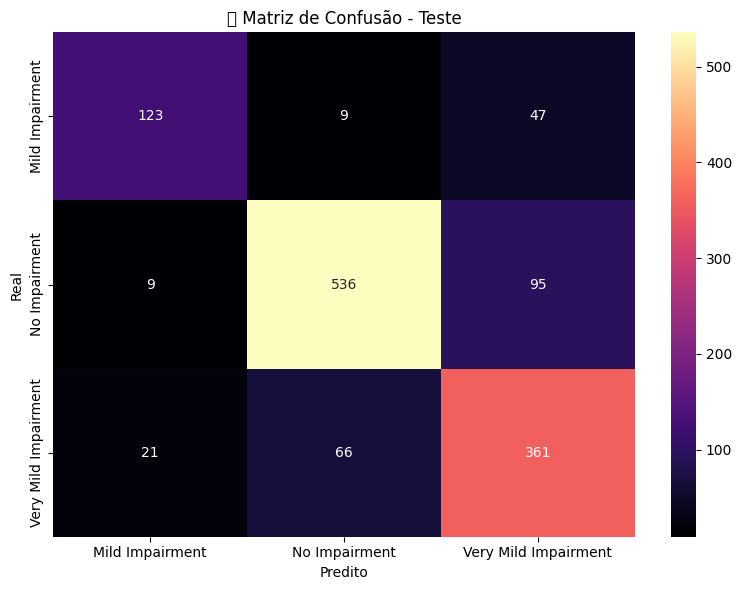

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np

# 🔍 Avaliação padrão
test_dir = './data_no_moderate/test'
test_ds_raw = tf.keras.utils.image_dataset_from_directory(test_dir, image_size=(224, 224), batch_size=16, label_mode='int')
normalization = tf.keras.layers.Rescaling(1./255)
num_classes = len(test_ds_raw.class_names)
test_ds = test_ds_raw.map(lambda x, y: (normalization(x), tf.one_hot(y, num_classes))).cache().prefetch(tf.data.AUTOTUNE)

best_model = load_model('resnet_finetuned_best_model_continue_partial.h5')

# val  accuracy
val_loss, val_accuracy = best_model.evaluate(val_ds)
print(f"\n📊 Val Accuracy: {val_accuracy * 100:.2f}%, Loss: {val_loss:.4f}")

test_loss, test_acc = best_model.evaluate(test_ds)
print(f"\n✅ Test Accuracy: {test_acc * 100:.2f}%, Loss: {test_loss:.4f}")


# 🔁 TTA
def predict_with_tta(model, dataset, num_passes=5):
    all_preds = []
    for i in range(num_passes):
        print(f"TTA Passagem {i+1}/{num_passes}")
        preds = []
        for batch, _ in dataset:
            augmented = tf.image.random_flip_left_right(batch)
            batch_preds = model.predict(augmented, verbose=0)
            preds.extend(batch_preds)
        all_preds.append(np.array(preds))
    return np.mean(np.array(all_preds), axis=0)

tta_preds = predict_with_tta(best_model, test_ds)
y_pred = np.argmax(tta_preds, axis=1)

# 🎯 Rótulos reais
y_true = []
for _, labels in test_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))

tta_acc = accuracy_score(y_true, y_pred)
print(f"\n🧪 Test Accuracy com TTA: {tta_acc * 100:.2f}%")

# 📋 Classification Report
print("\n📋 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=test_ds_raw.class_names))

# 🔥 Matriz de Confusão
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='magma', xticklabels=test_ds_raw.class_names, yticklabels=test_ds_raw.class_names)
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('🧩 Matriz de Confusão - Teste')
plt.tight_layout()
plt.show()


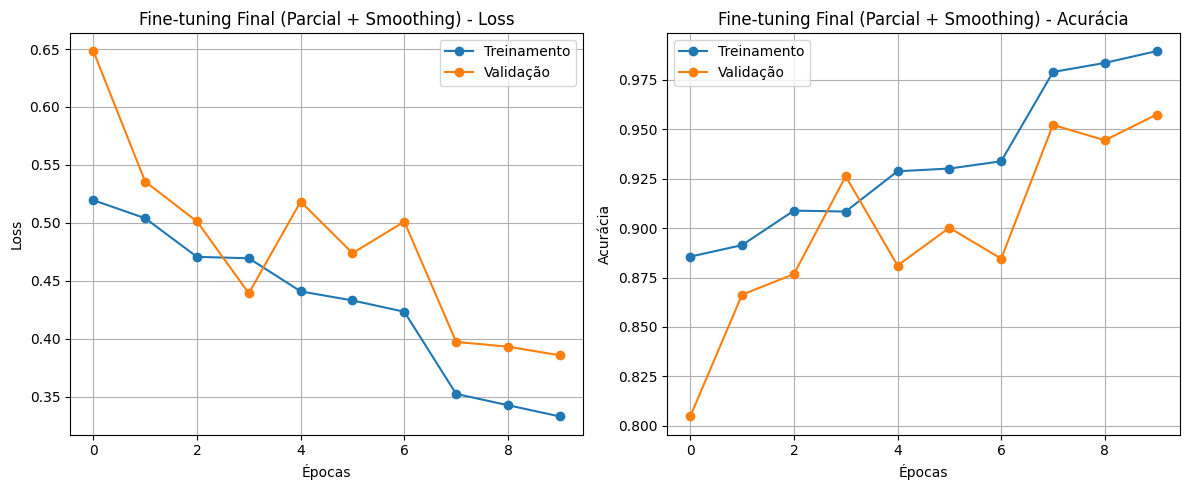

In [6]:
import matplotlib.pyplot as plt

def plot_history(history, title='Treinamento'):
    plt.figure(figsize=(12, 5))

    # 📉 Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Treinamento', marker='o')
    plt.plot(history.history['val_loss'], label='Validação', marker='o')
    plt.title(f'{title} - Loss')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # 📈 Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Treinamento', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validação', marker='o')
    plt.title(f'{title} - Acurácia')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# 🧠 Use após o treinamento
plot_history(history_continue, title="Fine-tuning Final (Parcial + Smoothing)")
